In [1]:
#import A

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.ticker as ticker

def sourcefunc_2D(x,y):
    f = (x**2 + y**2)*np.sin(x*y)
    return f

def boundary_2D(x,y):
    b = np.sin(x*y)
    return b

def sourcefunc_3D(x,y,z):
    f = ((y**2)*(x**2) + (y**2)*(z**2) + (z**2)*(x**2))*np.sin(x*y*z)
    return f

def boundary_3D(x,y,z):
    b = np.sin(x*y*z)
    return b

In [2]:
def create_Afuex_2D(sourcefunc_2D, boundary_2D, p):

    # Here I create the T_h and I_h matrices. These have precisely the same form as in the lecture notes. Some manual
    # stuff is done since we are working without elimination of boundary conditions
    h = 1/(2**p)
    N = 1/h
    N = int(N)
    Th = sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    T_h = np.pad(Th,1)
    T_h[0,0] = h**2
    T_h[N,N] = h**2
    Ih = sp.diags([1],[0], shape=(N-1, N-1)).toarray()
    I_h = np.pad(Ih,1)
    # The final A_h matrix is construced here. Because of the h^2 * I_{N+1} identity matrix in the very top left 
    # corner and bottom right corner I have to change four values manually from zero to 1
    A_2D = (1/(h**2))*np.kron(T_h, I_h) + (1/(h**2))*np.kron(I_h, T_h)
    A_2D[0,0] = 1
    A_2D[N,N] = 1
    A_2D[(N+1)**2-N-1,(N+1)**2-N-1] = 1
    A_2D[(N+1)**2-1,(N+1)**2-1] = 1
    
    
    # A meshgrid is created here on which I will evalute the source function. This vector is the right size for
    # the final result, but it includes every boundary value also, as evaluated through f. This is obviously wrong
    # as these boundary values should be evaluated through b, so that has to be adjusted. I therefore immediately 
    # introduce b1 and b_end as vectors which are the boundary values on the bottom and top of the grid, respectively.
    # f is also reshaped here to be a vector, not an array.
    x,y = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]
    x = x.transpose()
    y = y.transpose()

    f_2D = sourcefunc_2D(x,y)
    f_2D = np.reshape(f_2D, (N+1)*(N+1))

    x_axis = np.linspace(0, 1, num = N+1)
    b1 = boundary_2D(x_axis, 0)
    b_end = boundary_2D(x_axis, 1)
    
    # In this section I overwrite the parts of the f vector that represent boundary terms and next-to-boundary terms.
    # In the first loop I overwrite the first and last parts of f with b1 and b_end, so that the bottom and top of the 
    # 'grid' are boundary values. In the second loop I overwrite values representing the left and right side of the
    # 'grid'. Of course the bottom and left boundaries are just filled with zeros, as sin(xy) is zero when either x
    # or y is zero. In the third loop I overwrite the entries which represent positions next to the right boundary. In
    # the last loop I overwrite the entries which represent positions right below the top boundary. 


    for i in range(0, N+1):
        f_2D[i] = b1[i]
        f_2D[(N+1)*N + i] = b_end[i]

    for i in range(1,N):
        f_2D[i*(N+1)] = 0
        f_2D[i*(N+1)+ N] = boundary_2D(1, i*h)
    
    for i in range(0,N-1):    
        f_2D[2*N+i*(N+1)] = f_2D[2*N+i*(N+1)] + boundary_2D(1, (i+1)*h)/(h**2)
    
    for i in range(0,N-1):     
        f_2D[(N+1)**2-1-2*N+i] = f_2D[(N+1)**2-1-2*N+i] + b_end[i+1]/(h**2)
        
    u_ex_pre_2D = boundary_2D(x,y)
    u_ex_2D = np.reshape(u_ex_pre_2D, (1, (N+1)*(N+1)))
    
    
        
    return A_2D , f_2D , u_ex_2D, N

In [3]:
#Create array of A,f 's

#Create A,f,u_ex for various sizes 2D
data_2D = [0,0]
for p in range(2,8):
    #print(p)
    A_2D , f_2D, u_ex_2D, N = create_Afuex_2D(sourcefunc_2D, boundary_2D, p)
    #A_3D, f_3D, b_3D , u_ex_3D = create_Afuex_3D(A_2D, sourcefunc_3D, boundary_3D, p)
    data_2D.append((A_2D,f_2D,u_ex_2D))

In [67]:
#Define splitting M matrix for preconditioning

import scipy.sparse as sps

# M = 1/(w*(2-w))(D-wF)D^(-1)(D-wE) , with -F the upper triangular part of A and -E the lower triangular part!

#Choose some A
A = data_2D[6][0]
f = data_2D[6][1]
w = 1.5 #omega
#Define D,E,F
D = np.diag(np.diag(A))
Dinv = np.diag(1/np.diag(A))
E = -np.tril(A,-1)
F = -np.triu(A,+1)
RS = np.matmul(Dinv,D-w*E)
M = 1/(w*(2-w))*np.dot(D-w*F,RS)
M = sps.csr_matrix(M)
Minv = sps.linalg.inv(M)


#print(E.toarray())


/Users/bjarkehogdall/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:310: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/bjarkehogdall/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [69]:
#Preconditioned Conjugate Gradient method

def PCG(A,f,Minv,StopCrit):
    Minv = Minv.toarray()
    u = np.zeros(np.size(f))
    r = f
    residuals = np.array([np.linalg.norm(r,2)])
    err = np.linalg.norm(r,2)/np.linalg.norm(f,2)
    z = np.dot(Minv,r)
    p = z
    a = np.dot(r,z) / np.dot(p, np.dot(A,p) )
    u = u + a*p
    rnew = r - a*np.dot(A,p)
    residuals = np.append(residuals,np.linalg.norm(r,2))
    while err > StopCrit:
        znew = np.dot(Minv,rnew)
        b = np.dot(rnew,znew) / np.dot(r,z)
        p = znew + b*p
        z = znew
        r = rnew
        a = np.dot(r,z) / np.dot(p, np.dot(A,p) )
        u = u + a*p
        rnew = r - a*np.dot(A,p)
        residuals = np.append(residuals,np.linalg.norm(rnew,2))
        err = np.linalg.norm(r,2)/np.linalg.norm(f,2)
    return u , residuals


In [72]:
u , res = PCG(A,f,Minv,10E-10)
reducedres = res/np.linalg.norm(f,2)

print(np.linalg.norm(u-data_2D[6][2],np.inf))

0.0003112843371546925


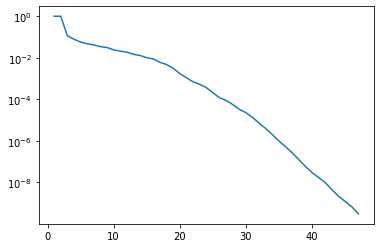

In [77]:
its = np.size(reducedres)
itx = np.linspace(1,its,its)

from matplotlib import pyplot as plt

fig , ax = plt.subplots()

ax.plot(itx,reducedres)
ax.set_yscale("log")


In [7]:
M = np.array([[1,2,3],[4,5,6],[7,8,9]])
V = np.array([1,2,4])

MV = np.dot(M,V)
print("MV:",MV)
VMV = np.dot(V,MV)
print("V.MV:",VMV)


MV: [17 38 59]
V.MV: 329
